# Обзорный анализ книжного магазина

Цели:

* Ознакомится с данными.
* Выполнить запросы SQL.

# Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, inspect

import os
from dotenv import load_dotenv

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (8, 3)})

%config InlineBackend.figure_format = 'retina'

# Работа с базой данных

Установим подключение к базе данных.

In [2]:
# Параметры соединения.
load_dotenv(dotenv_path='./credentials.env')
connection = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('USER'),
    os.getenv('PASSWORD'),
    os.getenv('HOST'),
    os.getenv('PORT'),
    os.getenv('DB'))

engine = create_engine(connection,
                       connect_args={'sslmode':'require'})

Функция для выгрузки данных.

In [3]:
def get_data(query, e=engine):
    return pd.read_sql(query, e)

Посмотрим доступные таблицы.

In [4]:
inspect(engine).get_table_names()

['orders',
 'visits',
 'advertisment_costs',
 'trip',
 'C:\x08oks',
 'boks',
 'finished_lessons1',
 'finished_lessons2',
 'publishers',
 'authors',
 'reviews',
 'ratings',
 'finished_lessons',
 'books']

Нас интересует 4 таблицы, ознакомимся с их содержимым.

In [5]:
for t in ['books', 'reviews', 'publishers', 'authors', 'ratings']:
    print(f'{t}'.center(102, '-'))
    display(get_data(f'select * from {t} limit 5'))

------------------------------------------------books-------------------------------------------------


,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


-----------------------------------------------reviews------------------------------------------------


,review_id,book_id,username,text
0,1,1,brandtandrea,Mention society tell send professor analysis. ...
1,2,1,ryanfranco,Foot glass pretty audience hit themselves. Amo...
2,3,2,lorichen,Listen treat keep worry. Miss husband tax but ...
3,4,3,johnsonamanda,Finally month interesting blue could nature cu...
4,5,3,scotttamara,Nation purpose heavy give wait song will. List...


----------------------------------------------publishers----------------------------------------------


,publisher_id,publisher
0,1,Ace
1,2,Ace Book
2,3,Ace Books
3,4,Ace Hardcover
4,5,Addison Wesley Publishing Company


-----------------------------------------------authors------------------------------------------------


,author_id,author
0,1,A.S. Byatt
1,2,Aesop/Laura Harris/Laura Gibbs
2,3,Agatha Christie
3,4,Alan Brennert
4,5,Alan Moore/David Lloyd


-----------------------------------------------ratings------------------------------------------------


,rating_id,book_id,username,rating
0,1,1,ryanfranco,4
1,2,1,grantpatricia,2
2,3,1,brandtandrea,5
3,4,2,lorichen,3
4,5,2,mariokeller,2


Получим название первой опубликованной книги с именем автора и издательства.

In [6]:
q = '''

WITH filtered_books AS
  (SELECT title,
          author_id,
          book_id,
          publisher_id
   FROM
     (SELECT b.*,
             ROW_NUMBER() OVER (PARTITION BY author_id
                                ORDER BY publication_date::date ASC) AS rn
      FROM books AS b) AS t
   WHERE rn = 1)
SELECT b.title,
       a.author,
       p.publisher
FROM filtered_books AS b
LEFT JOIN publishers AS p ON b.publisher_id = p.publisher_id
LEFT JOIN authors AS a ON b.author_id = a.author_id

'''
get_data(q)

,title,author,publisher
0,Possession,A.S. Byatt,Vintage
1,Aesop's Fables,Aesop/Laura Harris/Laura Gibbs,Oxford University Press
2,The Mysterious Affair at Styles (Hercule Poiro...,Agatha Christie,Deodand
3,Moloka'i (Moloka'i #1),Alan Brennert,St. Martin's Griffin
4,V for Vendetta,Alan Moore/David Lloyd,Vertigo
...,...,...,...
631,The Elements of Style,William Strunk Jr./E.B. White,Pearson
632,White Teeth,Zadie Smith,Vintage
633,The Egypt Game,Zilpha Keatley Snyder,Turtleback Books
634,Their Eyes Were Watching God,Zora Neale Hurston,Amistad


Построим гистограмму по средним оценкам для каждого обзорщика.

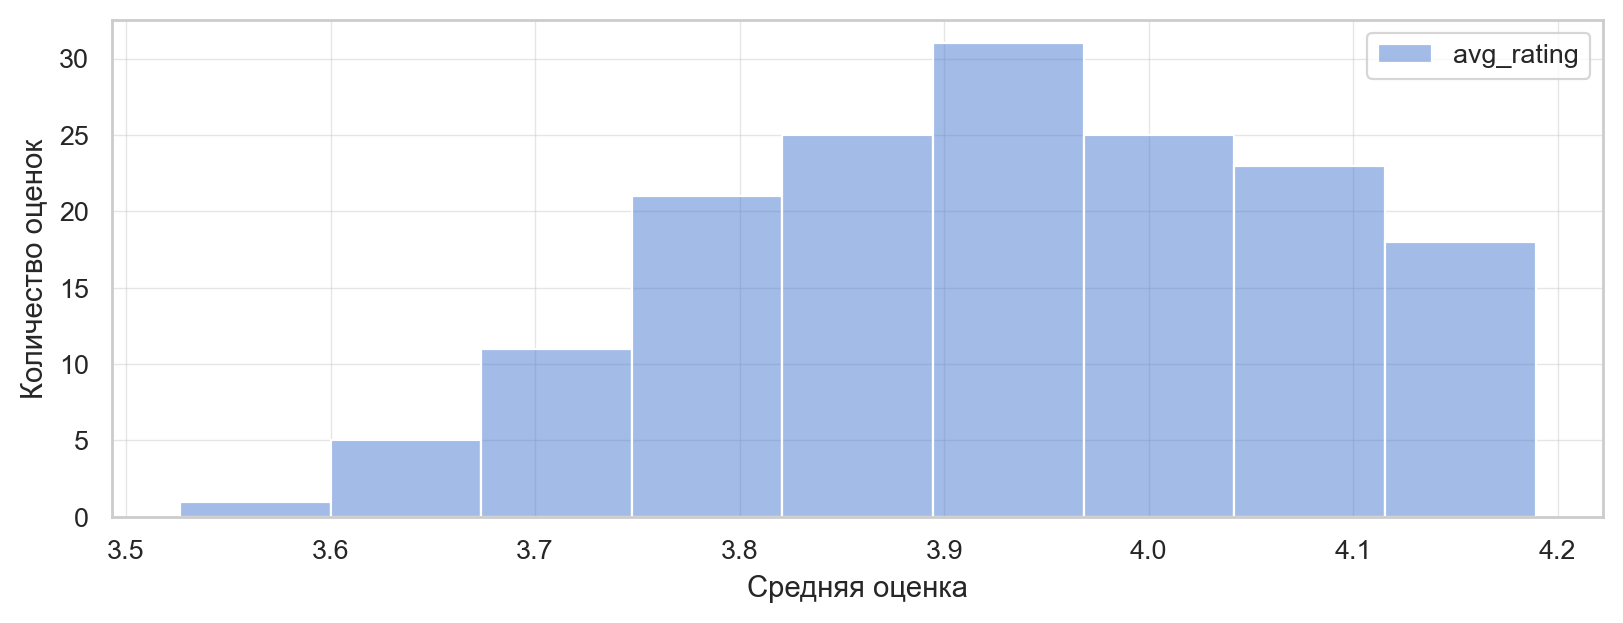

In [7]:
q = '''

SELECT username,
       avg(rating) AS avg_rating
FROM ratings
GROUP BY username

'''
data = get_data(q)

ax = sns.histplot(data=data)
ax.set_ylabel('Количество оценок')
ax.set_xlabel('Средняя оценка');

Найдем среднее количество обзоров от пользователей, которые поставили не менее 25 оценок

In [8]:
q = \
'''

WITH t1 AS
  (SELECT username
   FROM ratings
   GROUP BY username
   HAVING COUNT(rating) >= 25),
     t2 AS
  (SELECT count(r.review_id) AS cnt
   FROM reviews r
   JOIN t1 ON t1.username = r.username
   GROUP BY r.username)
SELECT avg(cnt) AS avg_review_cnt
FROM t2

'''
get_data(q)

,avg_review_cnt
0,17.456


Посчитаем количество отзывов, как видим у популярных изданий их 6-7, но есть и книги без отзывов.

In [9]:
q = '''

SELECT b.title,
       COALESCE(r.cnt, 0) AS reviews_cnt
FROM books b
LEFT JOIN
  (SELECT book_id,
          count(book_id) AS cnt
   FROM reviews
   GROUP BY book_id) AS r ON r.book_id = b.book_id
ORDER BY reviews_cnt

'''
get_data(q)

,title,reviews_cnt
0,Anne Rice's The Vampire Lestat: A Graphic Novel,0
1,The Cat in the Hat and Other Dr. Seuss Favorites,0
2,Essential Tales and Poems,0
3,The Natural Way to Draw,0
4,Disney's Beauty and the Beast (A Little Golden...,0
...,...,...
995,The Giver (The Giver #1),6
996,The Road,6
997,The Curious Incident of the Dog in the Night-Time,6
998,The Da Vinci Code (Robert Langdon #2),6


Определим автора с самой высокой средней оценкой книг, при учете только книг с 50 и более оценками.

In [10]:
q = '''

SELECT author,
       AVG(avg_rating) AS avg_rating
FROM
  (SELECT a.author,
          b.book_id,
          AVG(r.rating) AS avg_rating
   FROM authors a
   LEFT JOIN books b ON b.author_id = a.author_id
   LEFT JOIN ratings r ON r.book_id = b.book_id
   GROUP BY a.author,
            b.book_id
   HAVING COUNT(r.rating) >= 50) AS t
GROUP BY author
ORDER BY avg_rating DESC

'''
get_data(q)

,author,avg_rating
0,J.K. Rowling/Mary GrandPré,4.284
1,Markus Zusak/Cao Xuân Việt Khương,4.264
2,J.R.R. Tolkien,4.258
3,Louisa May Alcott,4.192
4,Rick Riordan,4.081
5,William Golding,3.901
6,J.D. Salinger,3.826
7,Paulo Coelho/Alan R. Clarke/Özdemir İnce,3.789
8,William Shakespeare/Paul Werstine/Barbara A. M...,3.788
9,Dan Brown,3.755
